## CPSC 8430 Fall 2024 HW_1_3c2

#### Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

#### Define DNN

In [2]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Utility functions

In [3]:
# Frobenius norm calculation (Sensitivity)
def frobenius_norm(model, inputs, labels, criterion):
    model.zero_grad() 
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward() 
    norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            norm += torch.norm(p.grad, p='fro').item()
    return norm


# Training Function
def train_model(model, train_loader, optimizer, criterion, epochs=10):
    model.train()
    train_loss = 0.0
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss = running_loss / len(train_loader)
    return train_loss

# Evaluation Function
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item()
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()
    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, accuracy

#### Load and prepare MNIST dataset

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST('./data_MNIST_1_3', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data_MNIST_1_3', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

#### Model training

In [5]:
batch_sizes = [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
train_losses = []
test_losses = []
accuracies = []
sensitivities = []

for batch_size in batch_sizes:
    print(f"Training with Batch Size: {batch_size}")
    model = DNN()  # Keep model size the same for comparison
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    train_loss = train_model(model, train_loader, optimizer, criterion, epochs=5)
    test_loss, accuracy = evaluate_model(model, test_loader, criterion)
    
    # Calculate sensitivity
    inputs, labels = next(iter(test_loader))
    sensitivity = frobenius_norm(model, inputs, labels, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    sensitivities.append(sensitivity)

Training with Batch Size: 4
Training with Batch Size: 8
Training with Batch Size: 16
Training with Batch Size: 32
Training with Batch Size: 64
Training with Batch Size: 128
Training with Batch Size: 256
Training with Batch Size: 512
Training with Batch Size: 1024
Training with Batch Size: 2048


#### Plotting

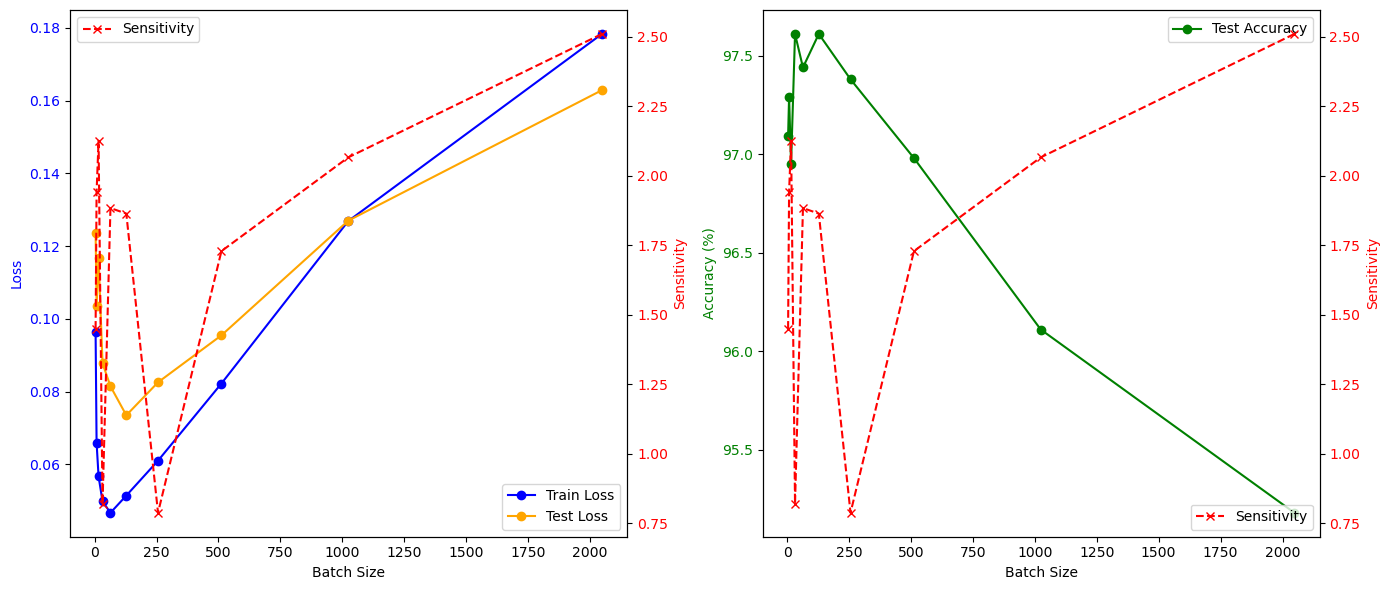

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Loss (train and test) and Sensitivity vs Batch Size
ax1.set_xlabel('Batch Size')
ax1.set_ylabel('Loss', color='blue')
ax1.plot(batch_sizes, train_losses, label="Train Loss", color='blue', marker='o')
ax1.plot(batch_sizes, test_losses, label="Test Loss", color='orange', marker='o')
ax1.tick_params(axis='y', labelcolor='blue')
ax1_sensitivity = ax1.twinx()  # second y-axis for Sensitivity
ax1_sensitivity.set_ylabel('Sensitivity', color='red')
ax1_sensitivity.plot(batch_sizes, sensitivities, label="Sensitivity", color='red', linestyle='--', marker='x')
ax1_sensitivity.tick_params(axis='y', labelcolor='red')
ax1.legend(loc='lower right')
ax1_sensitivity.legend(loc='best')

# Accuracy and Sensitivity vs Batch Size
ax2.set_xlabel('Batch Size')
ax2.set_ylabel('Accuracy (%)', color='green')
ax2.plot(batch_sizes, accuracies, label="Test Accuracy", color='green', marker='o')
ax2.tick_params(axis='y', labelcolor='green')
ax2_sensitivity = ax2.twinx()  # second y-axis for Sensitivity
ax2_sensitivity.set_ylabel('Sensitivity', color='red')
ax2_sensitivity.plot(batch_sizes, sensitivities, label="Sensitivity", color='red', linestyle='--', marker='x')
ax2_sensitivity.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='best')
ax2_sensitivity.legend(loc='lower right')

plt.tight_layout()
plt.show()